# San Francisco Crime On-line Analysis Processing in Apache Spark

## Outlines
1.   Performed spatial and time series analysis for 16-year, 0.5GB of recorded incidents from SFPD
2.   Built data ETL pipeline based on Spark, used Dataframe and Spark SQL for big data exploration
3.   Fine-tuned and applied ARIMA model to forecast the number of incidents in next five months, got 98% accuracy
4.   Visualized the spatial distribution of crimes based on K-means clustering algorithm in Spark ML

## Data source
   https://data.sfgov.org/Public-Safety/sf-data/skgt-fej3/data
   
## Content


*   **Data preprocessing**
*   **Data exploration**
        1. Counts the number of crimes for different category
        2. Counts the number of crimes for different district
        3. Find the trendency of crime number of each "Sunday" at "SF downtown" by UDF function      
        4. Analyze the trendency of crime from time sequence 
        5. Advice to visitor from analysis crime happening time
            obviously, it is safer to travel in SF downtown between  1pm - 3pm, 8pm - tommorw 11am
        6. Advice to distribute the police based on analysis crime time and categories
            we had better distribute more police in Southern and Northern, espcially in Southern 
            what's more, 1:00pm - 11:00pm in Southern always have large number of crime, 
            the police is supposed to pay attention to this period of time
        7. Advice to adapt the police base on crime resolution percentage
            theft crime is much higher than others, with suspending cases are nearly equal to the sum of others
            one of feasible suggestion is to distribute more police in theft crime
*   **Apply K-means to find the centriods of crimes** 
*   **ARIMA time series prediction**

## Data preprocessing

> Import package

In [5]:
#@title 
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *
import warnings

warnings.filterwarnings("ignore")

import os
os.environ["PYSPARK_PYTHON"] = "python3"
sns.set_style('whitegrid')

> Data loading

In [7]:
# read the data
crime_data_lines = sc.textFile('/csv/sf_data_before2018.csv')

#prepare data 
df_crimes = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])
#get header
header = df_crimes.first()
print(header)

#remove the first line of data
crimes = df_crimes.filter(lambda x: x != header)

#get the first line of data
display(crimes.take(3))

#get the total number of data 
print(crimes.count())

_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13,_14,_15,_16,_17,_18,_19,_20,_21,_22,_23,_24,_25,_26,_27,_28,_29,_30,_31,_32,_33
180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,05/15/2018,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.41191202732877,37.77520656149669,"(37.77520656149669, -122.41191202732877)",18036228907023,32,1,10,34,8,2,9,28853,34,,1,,1,,,2,,,1,
180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,05/15/2018,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.41925789481357,37.77514629165388,"(37.77514629165388, -122.41925789481357)",18036094864020,32,1,10,20,8,2,9,28853,19,,1,,1,,8,2,1,1,1,
180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087926150,53,3,2,20,2,4,7,28859,19,13,,15,3,15,,2,,,3,


> Data cleaning

In [9]:
df = crimes.toDF(['numID','category','descript','week','date','time','pdDist','resolution','address','latitude','longitude','location','pdID','sfNeighbor','curPdDist','surSuperDist','analysisNeighbor'])
df = df.select('numID','category','descript','week','date','time','pdDist','resolution','address','latitude','longitude','location','pdID','sfNeighbor','curPdDist','surSuperDist','analysisNeighbor')
display(df.take(10))
df.createOrReplaceTempView("sf_crime")
df.cache()

numID,category,descript,week,date,time,pdDist,resolution,address,latitude,longitude,location,pdID,sfNeighbor,curPdDist,surSuperDist,analysisNeighbor
180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,05/15/2018,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.41191202732877,37.77520656149669,"(37.77520656149669, -122.41191202732877)",18036228907023,32,1,10,34
180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,05/15/2018,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.41925789481357,37.77514629165388,"(37.77514629165388, -122.41925789481357)",18036094864020,32,1,10,20
180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087926150,53,3,2,20
180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965010,53,3,2,20
180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965015,53,3,2,20
180360829,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Tuesday,05/15/2018,01:27,MISSION,NONE,700 Block of SHOTWELL ST,-122.41561725232026,37.75641376904809,"(37.75641376904809, -122.41561725232026)",18036082965016,53,3,2,20
180360835,ROBBERY,"ROBBERY, BODILY FORCE",Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083503074,32,5,10,34
180360835,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083516710,32,5,10,34
180360794,LIQUOR LAWS,MISCELLANEOUS LIQOUR LAW VIOLATION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079417030,25,7,11,3
180360794,WARRANTS,ENROUTE TO OUTSIDE JURISDICTION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079462050,25,7,11,3


> Data schema

In [11]:
df.schema

Out[ 4 ]: StructType(List(StructField(numID,StringType,true),StructField(category,StringType,true),StructField(descript,StringType,true),StructField(week,StringType,true),StructField(date,StringType,true),StructField(time,StringType,true),StructField(pdDist,StringType,true),StructField(resolution,StringType,true),StructField(address,StringType,true),StructField(latitude,StringType,true),StructField(longitude,StringType,true),StructField(location,StringType,true),StructField(pdID,StringType,true),StructField(sfNeighbor,StringType,true),StructField(curPdDist,StringType,true),StructField(surSuperDist,StringType,true),StructField(analysisNeighbor,StringType,true)))

## Data Exploration

> 1. counts the number of crimes for different category.

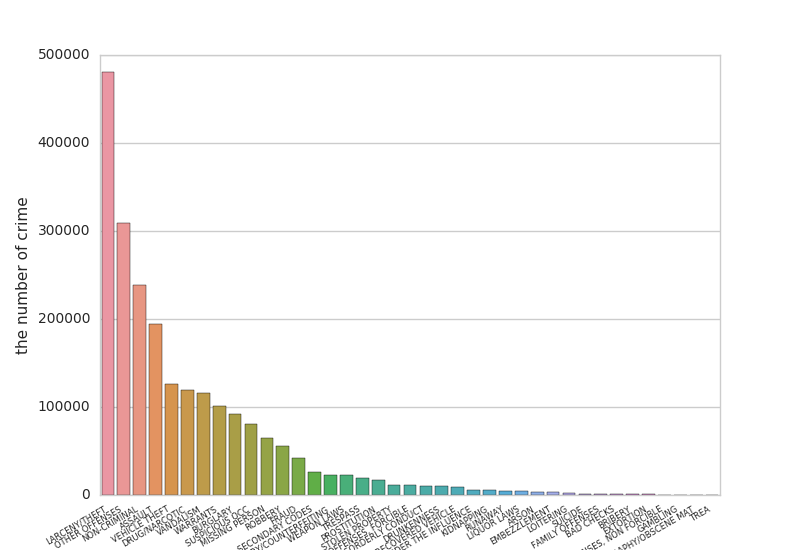

In [14]:
# SQL
q1 = spark.sql("SELECT COUNT(*) AS count, category FROM sf_crime Group By category Order By count DESC")
q1_df = q1.toPandas()
fig,ax = plt.subplots(nrows=1)
g = sns.barplot(x='category', y='count', ci=None, data=q1_df)
g.set_ylabel("the number of crime")
g.set_xlabel("crime category")
g.set_xticklabels(g.get_xticklabels(), rotation=30, fontsize=6, ha='right')   # avoid xlabel overlap
display(fig)

In [15]:
# spark df
q1 = df.groupBy('category').count().orderBy('count', ascending=False)
display(q1.take(10))

category,count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


> 2. Counts the number of crimes for different district

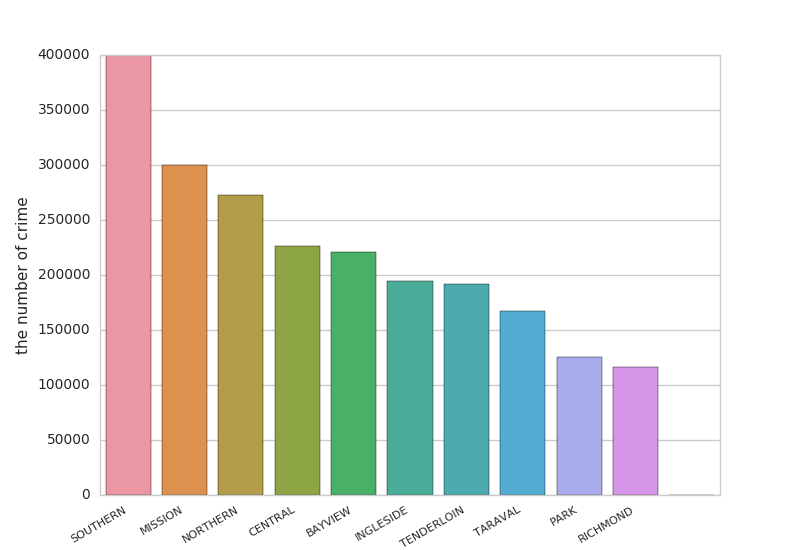

In [17]:
# sql
q2 = spark.sql("SELECT pdDist, COUNT(*) AS count FROM sf_crime GROUP BY pdDist ORDER BY count DESC")
q2_df = q2.toPandas()
fig,ax = plt.subplots(nrows=1)
g = sns.barplot(x='pdDist', y='count',ci=None,data=q2_df)
g.set_ylabel("the number of crime")
g.set_xlabel("district")
g.set_xticklabels(g.get_xticklabels(), rotation=30, fontsize=8, ha='right')   # avoid xlabel overlap
display(fig)

In [18]:
# spark df
q2 = df.groupBy('pdDist').count().orderBy('count', ascending=False)
display(q2.take(10))

pdDist,count
SOUTHERN,399785
MISSION,300076
NORTHERN,272713
CENTRAL,226255
BAYVIEW,221000
INGLESIDE,194180
TENDERLOIN,191746
TARAVAL,166971
PARK,125479
RICHMOND,116818


> 3. Using UDF function to count the number of crimes each "Sunday" at "SF downtown"

In [20]:
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import udf

def isDowntownBool(x, y):
  return True if 37.788566<float(y or 0)<37.799318 and -122.406513<float(x or 0)<-122.394881 else False    # range
isDowntown = udf(lambda x,y: isDowntownBool(x,y), BooleanType())          # pay attention here, there is null data, float(x or 0) to deal with

In [21]:
# spark df
q3 = df.where("week=='Sunday'").where(isDowntown('latitude', 'longitude')).groupBy('week','date').count().orderBy('date', ascending=False)
display(q3.take(10))

week,date,count
Sunday,12/31/2017,13
Sunday,12/31/2006,12
Sunday,12/30/2012,9
Sunday,12/30/2007,9
Sunday,12/29/2013,5
Sunday,12/28/2014,11
Sunday,12/28/2008,7
Sunday,12/28/2003,6
Sunday,12/27/2015,11
Sunday,12/27/2009,9


> 4. Analysis the number of crime in each month of 2015, 2016, 2017, 2018.

In [23]:
from pyspark.sql.types import IntegerType

def yearInt(x):
  return int(x.split('/')[2]) if x else 0
def monthInt(x):
  return int(x.split('/')[0]) if x else 0
def dayInt(x):
  return int(x.split('/')[1]) if x else 0

yearUDF = udf(lambda x: yearInt(x), IntegerType())
monthUDF = udf(lambda x: monthInt(x), IntegerType())
dayUDF = udf(lambda x: dayInt(x), IntegerType())

df = df.select('*', yearUDF('date').alias('year'), monthUDF('date').alias('month'), dayUDF('date').alias('day'))
df.createOrReplaceTempView("sf_crime")
df.cache()
display(df.take(10))

numID,category,descript,week,date,time,pdDist,resolution,address,latitude,longitude,location,pdID,sfNeighbor,curPdDist,surSuperDist,analysisNeighbor,year,month,day
180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,05/15/2018,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.41191202732877,37.77520656149669,"(37.77520656149669, -122.41191202732877)",18036228907023,32,1,10,34,2018,5,15
180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,05/15/2018,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.41925789481357,37.77514629165388,"(37.77514629165388, -122.41925789481357)",18036094864020,32,1,10,20,2018,5,15
180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087926150,53,3,2,20,2018,5,15
180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965010,53,3,2,20,2018,5,15
180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965015,53,3,2,20,2018,5,15
180360829,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Tuesday,05/15/2018,01:27,MISSION,NONE,700 Block of SHOTWELL ST,-122.41561725232026,37.75641376904809,"(37.75641376904809, -122.41561725232026)",18036082965016,53,3,2,20,2018,5,15
180360835,ROBBERY,"ROBBERY, BODILY FORCE",Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083503074,32,5,10,34,2018,5,15
180360835,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083516710,32,5,10,34,2018,5,15
180360794,LIQUOR LAWS,MISCELLANEOUS LIQOUR LAW VIOLATION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079417030,25,7,11,3,2018,5,15
180360794,WARRANTS,ENROUTE TO OUTSIDE JURISDICTION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079462050,25,7,11,3,2018,5,15


In [24]:
q4 = df.groupBy('year','month').count().select('year','month','count')
display(q4.take(10))

year,month,count
2012,10,13187
2007,6,11050
2005,5,12302
2010,12,10769
2010,7,10946
2015,2,12329
2017,3,13711
2008,8,11420
2017,8,12872
2014,4,12353


***Analysis:*** It seems that the number of crime is stable around 12k except there is a special month with rather low crime number.
But after analysis in time sequence, the number of crime is not stable

> 5. Travel suggestion to visit SF.

In [27]:
# assume we will travel on Dec 15
hours = [_ for _ in range(0,24)]   # 0-23
def hourInt(x):
  index = int(x.split(':')[0]) % 24
  return hours[index]
hourUDF = udf(lambda x:hourInt(x), IntegerType())
spark.udf.register("hourUDFsql", hourUDF)

Out[ 13 ]: <function __main__.<lambda>>

In [28]:
q5 = df.where('month==12').where('year==2015 or year==2016 or year==2017').where('day==15').groupBy('date', hourUDF('time').alias('hour')).count().orderBy('date','hour')
display(q5.take(10))

date,hour,count
12/15/2015,0,15
12/15/2015,1,6
12/15/2015,2,5
12/15/2015,3,4
12/15/2015,4,10
12/15/2015,5,3
12/15/2015,6,4
12/15/2015,7,8
12/15/2015,8,12
12/15/2015,9,10


***Suggestion:*** Obviously, it is safer to travel in SF downtown between  1pm - 3pm, 8pm - tommorw 11am

> 6. Advice to distribute the police based on analysis results.

In [31]:
# Step1:
q6_1 = df.groupBy('pdDist').count().orderBy('count', ascending=False).limit(3)
q6_1.createOrReplaceTempView("tmp_pdDist")
display(q6_1)

pdDist,count
SOUTHERN,399785
MISSION,300076
NORTHERN,272713


In [32]:
# Step2:
# Don't support embeded sql：https://blog.csdn.net/lihongyingaaa/article/details/80051011
# q6_2 = spark.sql("select pdDist, category, hourUDFsql(time) as hour from sf_crime from sf_crime where pdDist in (select pdDist from tmp_pdDist)")
q6_2 = df.where('pdDist=="SOUTHERN" or pdDist=="MISSION" or pdDist=="NORTHERN"').groupBy('pdDist', 'category', hourUDF('time').alias('hour')).count().toPandas()

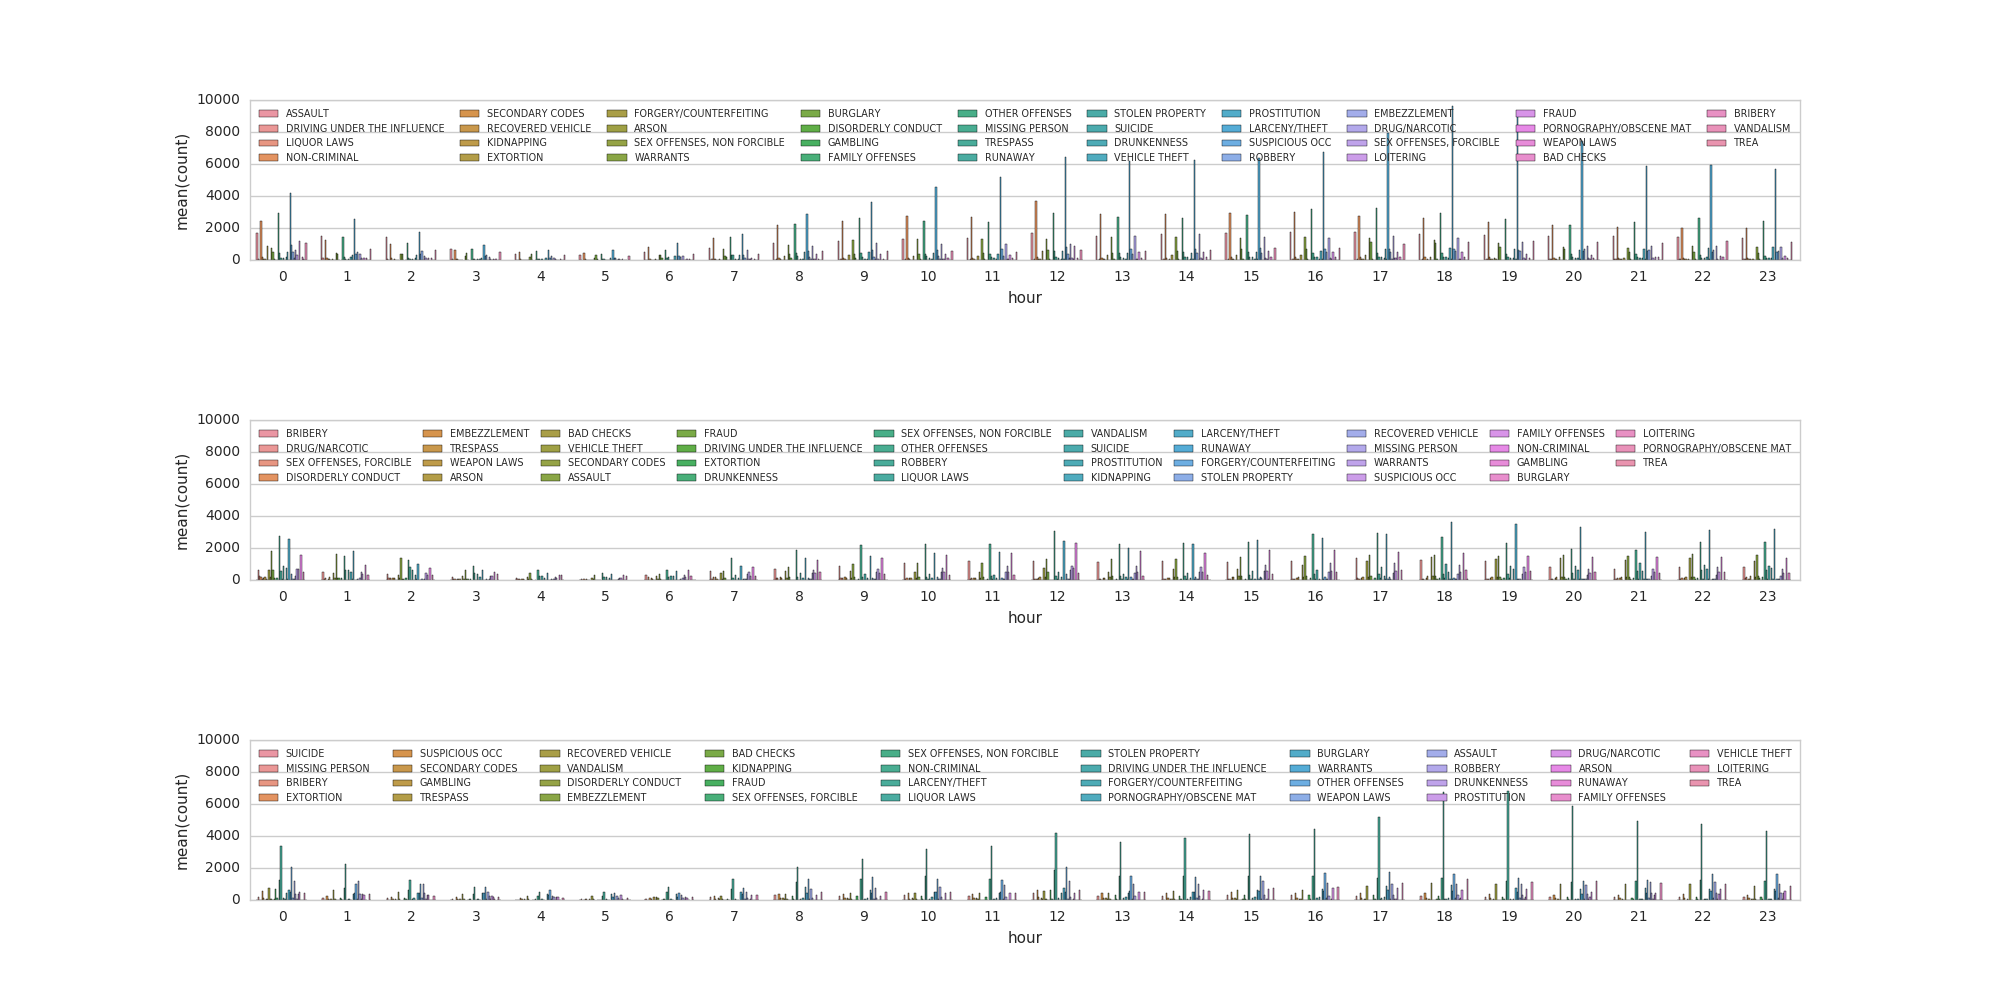

In [33]:
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(311)
g0 = sns.barplot(x='hour',y='count',hue='category',data=q6_2.loc[(q6_2['pdDist'] == 'SOUTHERN')], ax=ax0)
g0.legend(loc='best', mode='expand',fontsize='xx-small',ncol=10)
g0.set_ylim([0, 10000])
ax1 = fig.add_subplot(312)
g1 = sns.barplot(x='hour',y='count',hue='category',data=q6_2.loc[(q6_2['pdDist'] == 'MISSION')], ax=ax1)
g1.legend(loc='best', mode='expand',fontsize='xx-small',ncol=10)
g1.set_ylim([0, 10000])
ax2 = fig.add_subplot(313)
g2 = sns.barplot(x='hour',y='count',hue='category',data=q6_2.loc[(q6_2['pdDist'] == 'NORTHERN')], ax=ax2)
g2.legend(loc='best', mode='expand',fontsize='xx-small',ncol=10)
g2.set_ylim([0, 10000])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=1)
display(fig)

Advice:  From the figure, we can see, we had better distribute more police in Southern and Northern, espcially in Southern. What's more, 1:00pm - 11:00pm in Southern always have large number of crime, the police is supposed to pay attention to this period of time.

> 7. For different category of crime, find the percentage of resolution. Give advice to adjust the policy.

In [36]:
from pyspark.sql.functions import *

def isNullBool(x):
  return 0 if x.strip()=='NONE' else 1
isNullUDF = udf(lambda x: isNullBool(x), IntegerType())

tmp = df.select('category',isNullUDF('resolution').alias('state'))
q7 = tmp.groupBy('category').agg(count('*').alias('total'), sum('state').alias('done'), mean('state').alias('percentage')).toPandas()    
display(q7.head(10))

category,total,done,percentage
FRAUD,41542,9485,0.22832314284338742
SUICIDE,1292,310,0.23993808049535603
LIQUOR LAWS,4083,3632,0.8895420034288514
SECONDARY CODES,25831,11156,0.4318841701831133
FAMILY OFFENSES,1183,503,0.4251901944209637
MISSING PERSON,64961,34672,0.5337356259909792
OTHER OFFENSES,309358,221514,0.7160441947517117
DRIVING UNDER THE INFLUENCE,5672,5355,0.9441114245416079
WARRANTS,101379,95897,0.9459256848065181
ARSON,3931,757,0.19257186466547951


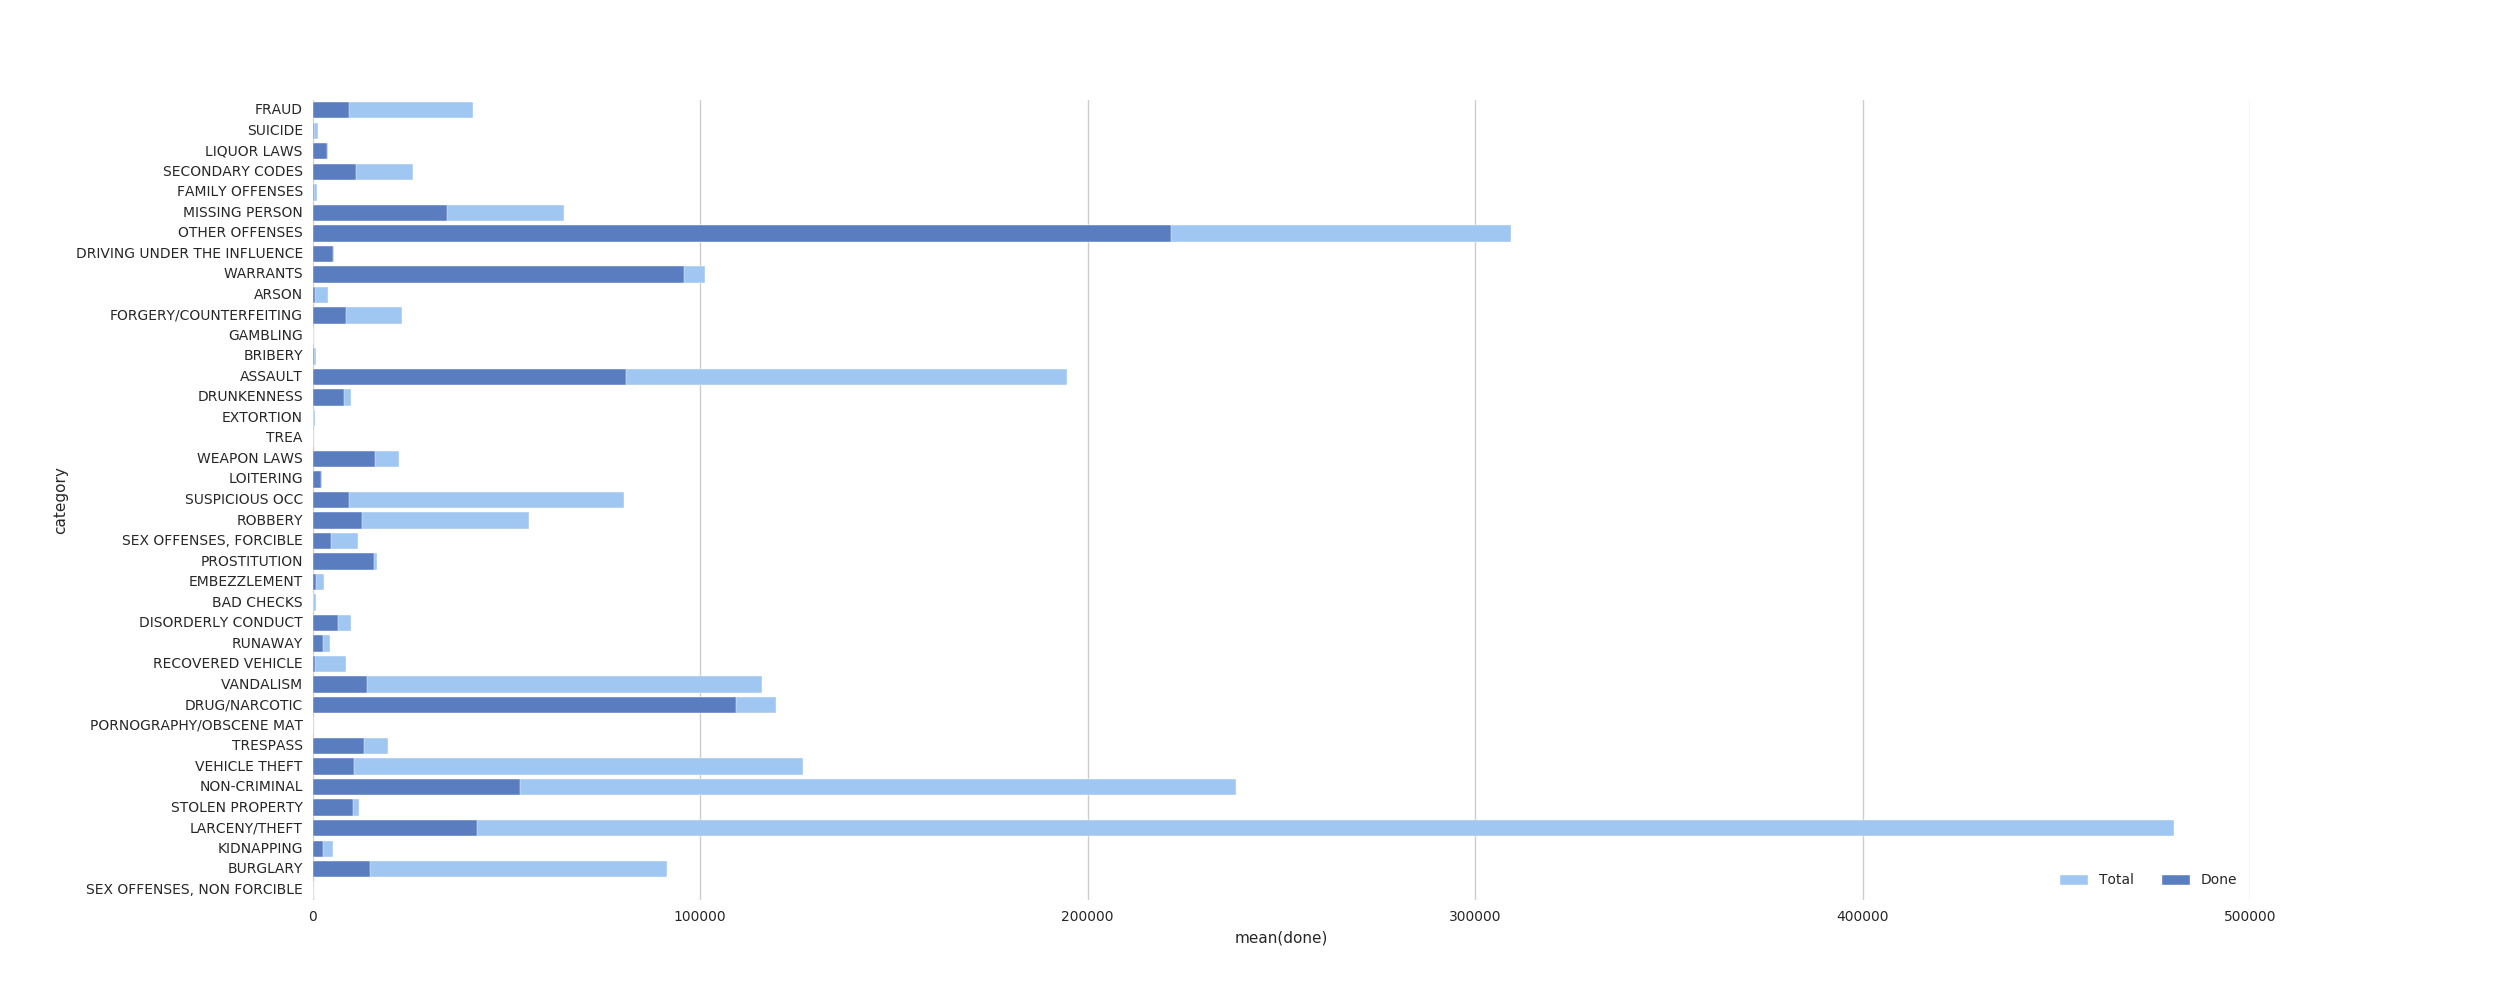

In [37]:
fig, ax = plt.subplots(figsize=(25,10))
# set count
sns.set_color_codes('pastel')
g0 = sns.barplot(x = 'total', y = 'category', data = q7, label = 'Total', color = 'b', edgecolor = 'w', ax=ax)
# set done
sns.set_color_codes('muted')
g1 = sns.barplot(x = 'done', y = 'category', data = q7, label = 'Done', color = 'b', edgecolor = 'w', ax=ax)
# set label
sns.despine(left = True, bottom = True)
ax.legend(ncol = 2, loc = 'lower right')
display(fig)    

For example, theft crime is obviously higher than others, and its suspending cases are nearly equal to the sum of other suspending cases. One of feasible suggestion is to distribute more police in theft crime.

## Apply Spark ML clustering for spatial data analysis
Extra: visualize the spatial distribution of crimes and run a kmeans clustering algorithm
Spark ML Kmeans reference: https://spark.apache.org/docs/latest/ml-clustering.html#k-means

In [40]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

tmp_df = df.select(df.longitude.cast('float').alias('long'), df.latitude.cast('float').alias('lati'))
vecAssembler = VectorAssembler(inputCols=["lati", "long"], outputCol="features")
new_df = vecAssembler.transform(tmp_df)
# new_df.show()
kmeans = KMeans(k=10, seed=1)  # 10 clusters here
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
# transformed.show()

# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(new_df)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 343.47351590065455
Cluster Centers: 
[-122.42437074 37.76548251]
[-120.5 90. ]
[-122.42338323 37.72721888]
[-122.40942405 37.78616336]
[-122.48176379 37.73644669]
[-122.39177502 37.73000979]
[-122.48205133 37.77125024]
[-122.45153894 37.72107234]
[-122.40747993 37.75605035]
[-122.4407457 37.78269975]

In [41]:
display(transformed.take(10))

long,lati,features,prediction
37.77520751953125,-122.41191101074219,"List(1, 2, List(), List(-122.41191101074219, 37.77520751953125))",3
37.775146484375,-122.41925811767578,"List(1, 2, List(), List(-122.41925811767578, 37.775146484375))",0
37.75709915161133,-122.41781616210938,"List(1, 2, List(), List(-122.41781616210938, 37.75709915161133))",8
37.75709915161133,-122.41781616210938,"List(1, 2, List(), List(-122.41781616210938, 37.75709915161133))",8
37.75709915161133,-122.41781616210938,"List(1, 2, List(), List(-122.41781616210938, 37.75709915161133))",8
37.756412506103516,-122.41561889648438,"List(1, 2, List(), List(-122.41561889648438, 37.756412506103516))",8
37.781951904296875,-122.41004180908203,"List(1, 2, List(), List(-122.41004180908203, 37.781951904296875))",3
37.781951904296875,-122.41004180908203,"List(1, 2, List(), List(-122.41004180908203, 37.781951904296875))",3
37.76984786987305,-122.44776153564453,"List(1, 2, List(), List(-122.44776153564453, 37.76984786987305))",9
37.76984786987305,-122.44776153564453,"List(1, 2, List(), List(-122.44776153564453, 37.76984786987305))",9


## ARIMA: Time series analysis
This part is not based on Spark, and only based on Pandas Time Series package.   
Steps:  
1.visualize time series  
2.plot ACF and find optimal parameter  
3.Train ARIMA  
4.Prediction

### Import package

In [44]:
from statsmodels.graphics.tsaplots import plot_acf  #self-corelation
from statsmodels.tsa.stattools import adfuller as ADF  #stability test
from statsmodels.graphics.tsaplots import plot_pacf    #partial autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox    #white noise test
from statsmodels.tsa.arima_model import ARIMA

### Find the relationship in time sequence, maybe day, or month

In [46]:
from pyspark.sql.functions import *
# Method 1: transfer string to date
# from pyspark.sql.functions import unix_timestamp
# from pyspark.sql.functions import from_unixtime
# data = df.select('category', from_unixtime(unix_timestamp('date', 'MM/dd/yyy')).alias('date'))

from datetime import datetime
from pyspark.sql.types import DateType
strToDate =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())
# data = df.select(strToDate('date').alias('date'), 'category')
# data = data.groupBy('date').agg(count('*').alias('count')).orderBy('date').select('date','count').toPandas()
data = df.groupBy(strToDate('date').alias('date')).agg(count('*').alias('count')).orderBy('date').select('date','count').toPandas()
display(data.head(10))

date,count
2003-01-01,622
2003-01-02,411
2003-01-03,440
2003-01-04,347
2003-01-05,377
2003-01-06,400
2003-01-07,418
2003-01-08,528
2003-01-09,417
2003-01-10,399


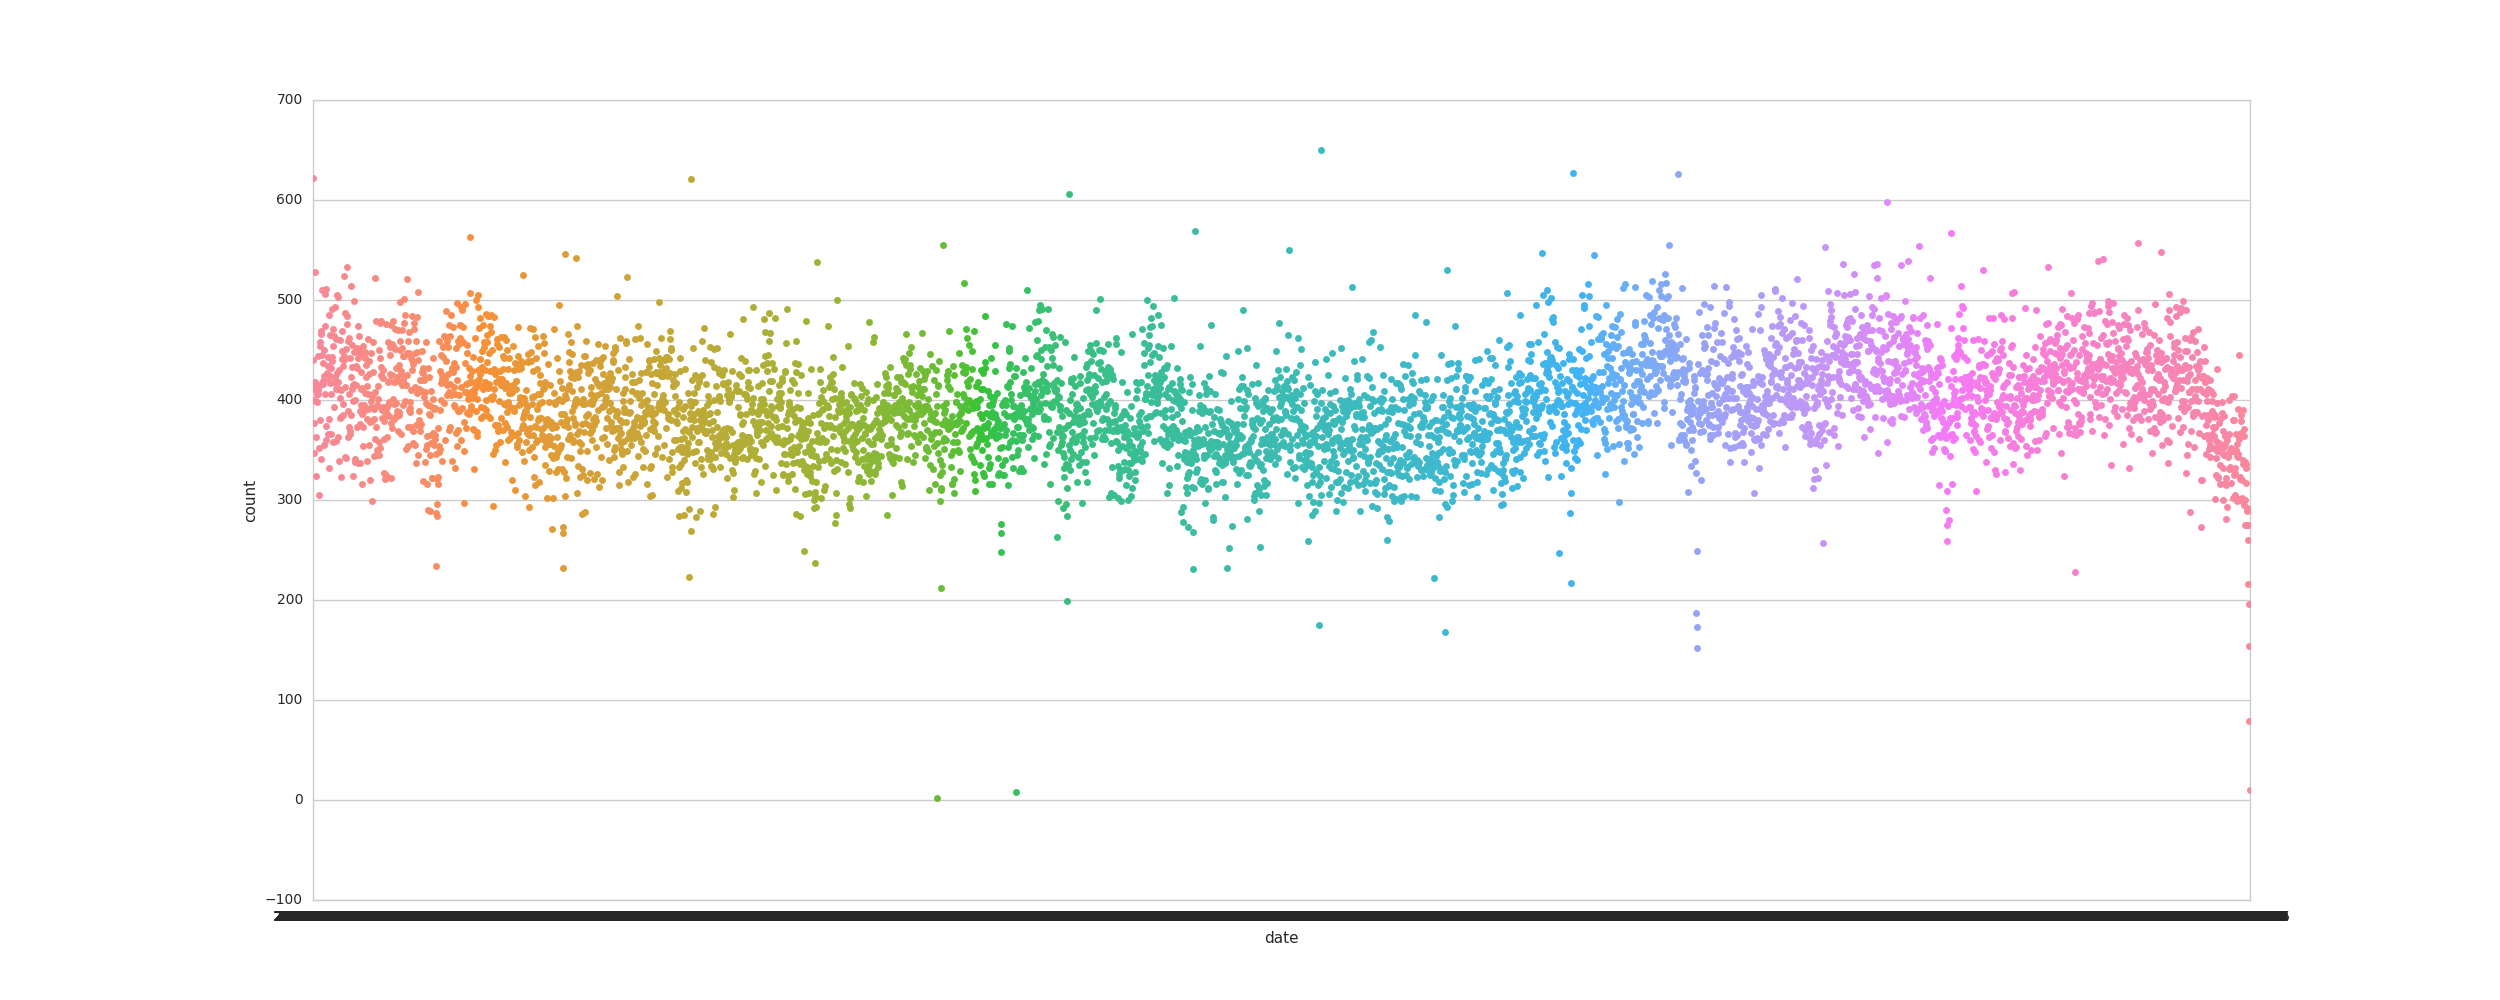

In [47]:
fig, ax = plt.subplots(figsize=(25,10))
g = sns.stripplot(x="date", y="count", data=data, ax=ax)
display(fig)

In [48]:
subdata = df.groupBy(strToDate('date').alias('date'),'category').count().orderBy('date').select('date','category','count').toPandas()

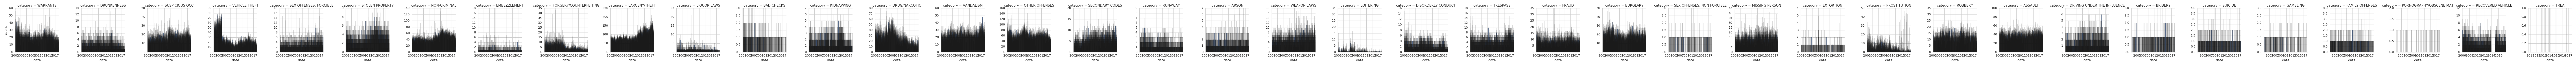

In [49]:
g = sns.FacetGrid(col='category', data=subdata, sharex=False, sharey=False)      # provide col name
g = g.map(plt.bar, "date", "count", alpha=0.8)
display(g.fig)

In [50]:
data = df.groupBy('year','month').count().orderBy('year','month').select('year','month','count').toPandas()

data['year'] = data['year'].map(str)
data['month'] = data['month'].map(str)
data['time'] = data['year'].str.cat(data['month'],sep='-')
data = data.drop(['year','month'],1)
display(data.head(10))

count,time
12956,2003-1
11924,2003-2
12998,2003-3
12741,2003-4
12605,2003-5
11934,2003-6
12379,2003-7
12893,2003-8
12798,2003-9
13050,2003-10


## Choose the monthly count to model ARIMA

In [52]:
print(data.count())
data = data.drop([180,181,182,183,184])
print(data.count())

count 185
time 185
dtype: int64
count 180
time 180
dtype: int64

In [53]:
# data.set_index("time", inplace=True)
ac_data = data.set_index("time")
ac_data.index = pd.DatetimeIndex(ac_data.index)

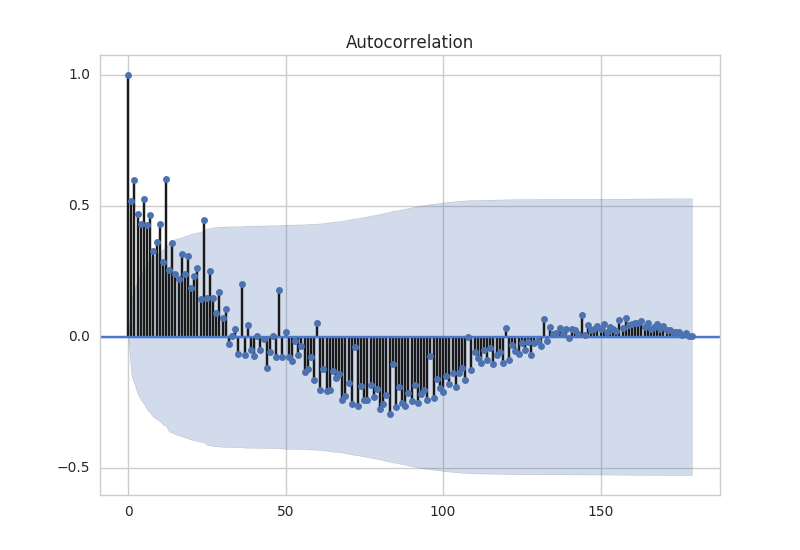

In [54]:
display(plot_acf(ac_data))

In [55]:
print('The result of the original sequence of ADF is：', ADF(ac_data['count']))

The result of the original sequence of ADF is： (-1.3299561866805008, 0.61535835496648306, 12, 167, {'10%': -2.5760826967621644, '5%': -2.8790075987120027, '1%': -3.4701264260714471}, 2532.7496336972404)

p value = 0.6153 >> 0.05，so we cannot reject H0: This is not a stationary series(H0) and score = -1.95, score > 10% cannot reject

In [57]:
# after the first difference
D_data = ac_data.diff().dropna()   # drop na value
D_data.columns = ['different']  # change column name
display(D_data.head(10)) # show result

different
-1032.0
1074.0
-257.0
-136.0
-671.0
445.0
514.0
-95.0
252.0
-1223.0


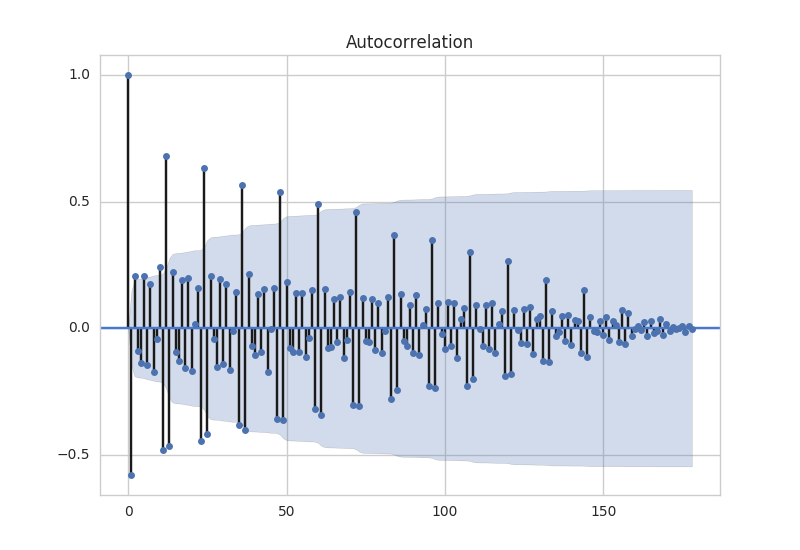

In [58]:
display(plot_acf(D_data))

In [59]:
print('The result of white noise of differenced sequence：', acorr_ljungbox(D_data, lags=1)) # return p value of white noise

The result of white noise of differenced sequence： (array([ 61.22682098]), array([ 5.08638724e-15]))

the return value are: Chi-square distribution and p value, p value == 5.08638e-15 << 0.05. So we can reject H0, we can state this sequence is not white nose sequence

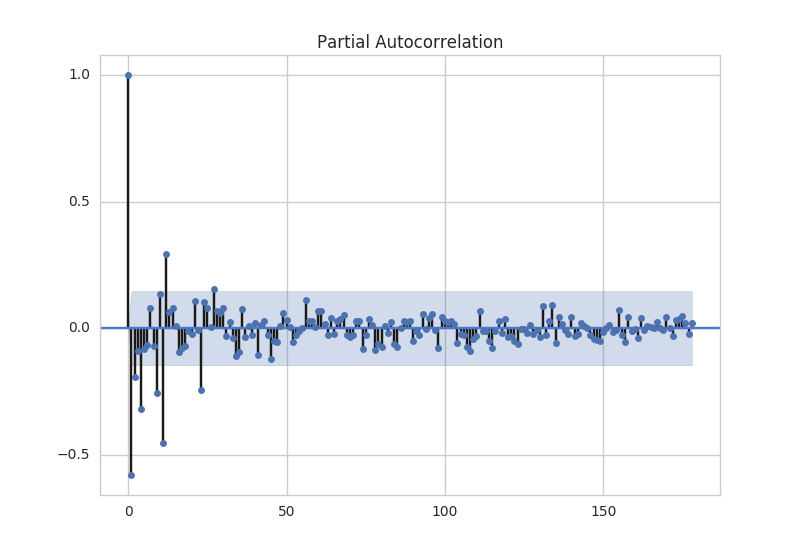

In [61]:
display(plot_pacf(D_data))

In [62]:
ac_data['count'] = ac_data['count'].astype(float)

In [63]:
# search the order
# pmax = int(len(D_data)/10) #usually not over length/10, here is 18, too slow
# qmax = int(len(D_data)/10) #usually not over length/10, here is 18
pmax = 10
qmax = 10
bic_matrix = [] #bic matrix
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        try: # sometimes report error
            tmp.append(ARIMA(ac_data, (p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

bic_matrix = pd.DataFrame(bic_matrix) # find minimum one
p,q = bic_matrix.stack().idxmin() # using stack to unfold the data and find minimum one
print('BIC minimum p-value and q-value are：%s、%s' %(p,q))  # output the minimum p and q value

model = ARIMA(ac_data, (p,1,q)).fit() #establish ARIMA(6, 1, 7) model
print(model.summary2()) #give a report

BIC minimum p-value and q-value are：6、7
 Results: ARIMA
====================================================================
Model: ARIMA Log-Likelihood: -1364.5 
Dependent Variable: D.count Scale: 1.0000 
Date: 2019-07-30 05:37 Method: css-mle 
No. Observations: 179 Sample: 02-01-2003
Df Model: 14 12-01-2017
Df Residuals: 165 S.D. of innovations: 467.244 
AIC: 2759.0829 HQIC: 2778.470 
BIC: 2806.8937 
--------------------------------------------------------------------
 Coef. Std.Err. t P>|t| [0.025 0.975]
--------------------------------------------------------------------
const -3.9267 16.0893 -0.2441 0.8075 -35.4611 27.6078
ar.L1.D.count -1.7353 0.0074 -234.7757 0.0000 -1.7498 -1.7208
ar.L2.D.count -2.0062 0.0112 -179.7684 0.0000 -2.0280 -1.9843
ar.L3.D.count -1.7416 0.0145 -120.3553 0.0000 -1.7700 -1.7133
ar.L4.D.count -2.0064 0.0132 -152.0004 0.0000 -2.0323 -1.9805
ar.L5.D.count -1.7343 0.0086 -201.9560 0.0000 -1.7511 -1.7174
ar.L6.D.count -0.9988 0.0027 -373.8579 0.0000 -1.0040 -0.9935
ma.L1.D.count 1.1989 0.0790 15.1803 0.0000 1.0441 1.3537
ma.L2.D.count 1.0740 0.1424 7.5398 0.0000 0.7948 1.3532
ma.L3.D.count 0.6412 0.1597 4.0155 0.0001 0.3282 0.9541
ma.L4.D.count 1.0667 0.1274 8.3695 0.0000 0.8169 1.3165
ma.L5.D.count 0.6278 0.1408 4.4599 0.0000 0.3519 0.9036
ma.L6.D.count 0.0367 0.1273 0.2881 0.7736 -0.2128 0.2862
ma.L7.D.count -0.5506 0.0744 -7.3974 0.0000 -0.6965 -0.4047
-----------------------------------------------------------------------------
 Real Imaginary Modulus Frequency
-----------------------------------------------------------------------------
AR.1 0.4987 -0.8668 1.0001 -0.1669
AR.2 0.4987 0.8668 1.0001 0.1669
AR.3 -0.8665 -0.4994 1.0001 -0.4168
AR.4 -0.8665 0.4994 1.0001 0.4168
AR.5 -0.5004 -0.8663 1.0004 -0.3334
AR.6 -0.5004 0.8663 1.0004 0.3334
MA.1 -0.8618 -0.5072 1.0000 -0.4153
MA.2 -0.8618 0.5072 1.0000 0.4153
MA.3 -0.5083 -0.8612 1.0000 -0.3349
MA.4 -0.5083 0.8612 1.0000 0.3349
MA.5 0.4954 -0.8687 1.0000 -0.1675
MA.6 0.4954 0.8687 1.0000 0.1675
MA.7 1.8162 -0.0000 1.8162 -0.0000
====================================================================

In [64]:
result_predic = model.forecast(5) # return prediction, std error, confidence intervals
print(result_predic)

(array([ 13099.94348865, 12483.96050008, 13384.15092688, 12843.14272117,
 12554.4459951 ]), array([ 467.2437814 , 515.02440539, 558.47910778, 595.15260403,
 635.29678789]), array([[ 12184.16250511, 14015.7244722 ],
 [ 11474.53121435, 13493.38978581],
 [ 12289.5519895 , 14478.74986425],
 [ 11676.66505198, 14009.62039037],
 [ 11309.28717135, 13799.60481885]]))

## Compare the prediction and the true value

In [66]:
new_data = sc.textFile("/csv/sf_data_after2018.csv")
#prepare data 
new_data = new_data.map(lambda line: [x.strip('"') for x in next(reader([line]))])
#get header
header = new_data.first()
print(header)
#remove the first line of data
new_crimes = new_data.filter(lambda x: x != header)
#get the total number of data 
print(new_crimes.count())
new_df = new_crimes.toDF()
new_df.cache()

['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year', 'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID', 'Incident Number', 'CAD Number', 'Report Type Code', 'Report Type Description', 'Filed Online', 'Incident Code', 'Incident Category', 'Incident Subcategory', 'Incident Description', 'Resolution', 'Intersection', 'CNN', 'Police District', 'Analysis Neighborhood', 'Supervisor District', 'Latitude', 'Longitude', 'point', 'SF Find Neighborhoods', 'Current Police Districts', 'Current Supervisor Districts', 'Analysis Neighborhoods', 'HSOC Zones as of 2018-06-05', 'OWED Public Spaces', 'Central Market/Tenderloin Boundary Polygon - Updated', 'Parks Alliance CPSI (27+TL sites)']
205146
 Out[ 44 ]: DataFrame[_1: string, _2: string, _3: string, _4: string, _5: string, _6: string, _7: string, _8: string, _9: string, _10: string, _11: string, _12: string, _13: string, _14: string, _15: string, _16: string, _17: string, _18: string, _19: string, _20: string, _21: string, _22: string, _23: string, _24: string, _25: string, _26: string, _27: string, _28: string, _29: string, _30: string, _31: string, _32: string, _33: string, _34: string]

In [67]:
new_data = new_df.toPandas()
new_data = new_data[['_2','_7']]
new_data.columns = ['date','numID']

def getYearMonth(s):
  return s.split("/")[0]+"-"+s.split("/")[1]
new_data['time']= new_data['date'].apply(lambda x: getYearMonth(x))
display(new_data.head(10))

date,numID,time
2018/12/02,74374327130,2018-12
2018/12/01,74370071000,2018-12
2019/03/18,78164004134,2019-03
2019/03/20,78169706244,2019-03
2019/03/12,78154706372,2019-03
2019/03/19,78160405071,2019-03
2019/03/20,78181007043,2019-03
2019/02/17,77232971000,2019-02
2019/02/21,77223707043,2019-02
2019/03/19,78145019057,2019-03


In [68]:
result_real = new_data.groupby('time').size().reset_index(name="count")
display(result_real)

time,count
2018-01,13400
2018-02,11927
2018-03,12601
2018-04,12586
2018-05,13016
2018-06,12488
2018-07,13925
2018-08,13921
2018-09,12864
2018-10,13307


In [69]:
result_real = result_real[:5]    # 2018/1 - 2018-5
display(result_real)

time,count
2018-01,13400
2018-02,11927
2018-03,12601
2018-04,12586
2018-05,13016


In [70]:
result = result_real.copy()
result.insert(2, 'predic', list(map(int, result_predic[0])))
result.insert(3, 'std', list(map(int, result_predic[1])))
low = [result_predic[2][i][0] for i in range(len(result_predic[2]))]
high = [result_predic[2][i][1] for i in range(len(result_predic[2]))]
result.insert(4, 'low', list(map(int, low)))
result.insert(5, 'high', list(map(int, high)))
display(result)

time,count,predic,std,low,high
2018-01,13400,13099,467,12184,14015
2018-02,11927,12483,515,11474,13493
2018-03,12601,13384,558,12289,14478
2018-04,12586,12843,595,11676,14009
2018-05,13016,12554,635,11309,13799


In [71]:
accuracy = result.loc[(result['low']<= result['predic']) & (result['predic']<= result['high'])]['time'].count() / result['time'].count()
print('the accuracy of prediction of the next 5 month 2018.1-2018.5 is:  {}%'.format(int(accuracy*100)))

the accuracy of prediction of the next 5 month 2018.1-2018.5 is: 100%

The model does well in time sequence prediction. Accuracy is 100%.